In [1]:
from qiskit.circuit.library import RealAmplitudes

In [2]:
from qiskit import QuantumCircuit, transpile

In [3]:
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
import numpy as np

In [4]:
from sklearn import datasets

In [158]:
digits = datasets.load_digits()

In [159]:
digits['data']

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [160]:
zeros_data=digits['data'][digits['target'].argsort()][0:100]

In [161]:
ones_data=digits['data'][digits['target'].argsort()][177+1:177+101]

In [162]:
zeros_label=digits['target'][digits['target'].argsort()][0:100]

In [163]:
ones_label=digits['target'][digits['target'].argsort()][177+1:177+101]

In [164]:
data=np.vstack((zeros_data,ones_data))

In [165]:
label=np.hstack((zeros_label,ones_label))

In [166]:
label.shape

(200,)

In [167]:
zeros_data_test=digits['data'][digits['target'].argsort()][100:110]
ones_data_test=digits['data'][digits['target'].argsort()][177+101:177+111]
zeros_label_test=digits['target'][digits['target'].argsort()][100:110]
ones_label_test=digits['target'][digits['target'].argsort()][177+101:177+111]
data_test=np.vstack((zeros_data_test,ones_data_test))
label_test=np.hstack((zeros_label_test,ones_label_test))

In [168]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [169]:
tsvd = TruncatedSVD(n_components=2)
data = tsvd.fit_transform(data)

In [170]:
tsvd = TruncatedSVD(n_components=2)
data_test = tsvd.fit_transform(data_test)

In [171]:
data=data/np.abs(data).max()

In [172]:
data_test=data_test/np.abs(data_test).max()

In [20]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

In [21]:
def bce(predict,label):
    return -(label*np.log(predict)+(1-label)*np.log(1-predict))

In [22]:
feature_dim = 2
pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z','X','ZY']).decompose()

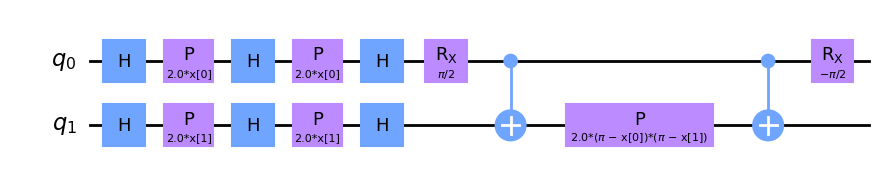

In [23]:
pauli_feature_map.draw(output="mpl")

In [24]:
ansatz=RealAmplitudes(num_qubits=2,reps=1,entanglement="linear").decompose()

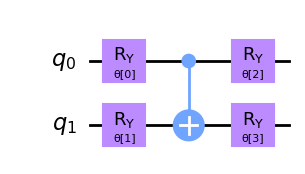

In [25]:
ansatz.draw(output='mpl')

In [26]:
circuit = QuantumCircuit(2, 2)

In [27]:
circuit = circuit.compose(pauli_feature_map,[0,1])

In [28]:
circuit = circuit.compose(ansatz,[0,1])

In [29]:
circuit.measure([0,1],[0,1])

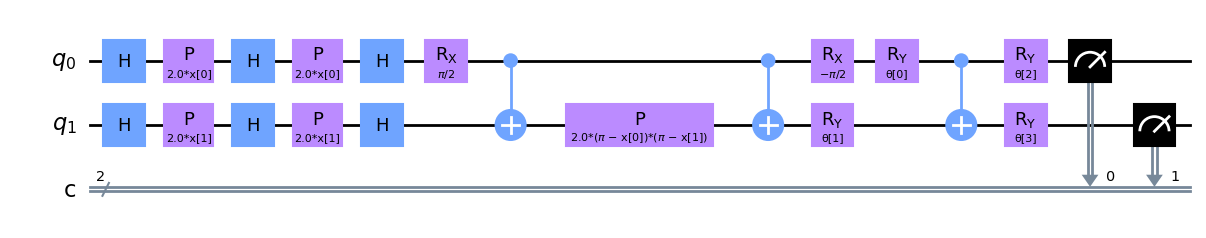

In [30]:
circuit.draw(output='mpl')

In [55]:
def get_output(circuit,x,para):
    value_dict_1 = dict(zip(pauli_feature_map.parameters,x))
    value_dict_2 = dict(zip(ansatz.parameters,para))
    value_dict=Merge(value_dict_1, value_dict_2)
    new_cq=circuit.assign_parameters(value_dict, inplace=False)
    simulator = QasmSimulator()
    compiled_circuit = transpile(new_cq, simulator)
    job = simulator.run(compiled_circuit, shots=1000)
    result = job.result()
    counts = result.get_counts(compiled_circuit)
    distribution=[0,0]
    for key in counts.keys():
        if key == "00" and "11":
            distribution[0]=distribution[0]+counts[key]
        else:
            distribution[1]=distribution[1]+counts[key]
    predict = distribution[0]/(distribution[0]+distribution[1])
    return predict

In [56]:
def get_loss(circuit,x,para,y):
    output=get_output(circuit,x,para)
    return np.abs(output-y)

In [57]:
def gradient_calculate(circuit,x,para,y,index,eps=np.pi/2):
    e_i = np.identity(para.size)[:,index]
    plus = para + eps*e_i
    minus = para - eps*e_i
    gradient = (get_loss(circuit,x,plus,y)-get_loss(circuit,x,minus,y))/2
    return gradient

In [58]:
def gradient_decent(circuit,x,para,y):
    para_new = np.copy(para)
    for index in range(len(para)): 
        gradient = gradient_calculate(circuit,x,para,y,index)
        para_new[index] = para[index] - 0.1*gradient
    return para_new

In [59]:
para = np.random.random(ansatz.num_parameters)

In [60]:
para

array([0.37987237, 0.90804455, 0.53014987, 0.75045538])

In [61]:
get_loss(circuit,data[0],para,label[0])

0.096

In [62]:
para_new=gradient_decent(circuit,data[0],para,label[0])

In [63]:
get_loss(circuit,data[0],para_new,label[0])

0.112

In [86]:
para_new=gradient_decent(circuit,data[0],para_new,label[0])

In [87]:
get_loss(circuit,data[0],para_new,label[0])

0.07

data=[[0,0],[1,1],[2,2],[3,3],[4,4],[5,5]]
label=[0,0,0,1,1,1]
label=np.array(label)

In [173]:
para = np.random.random(ansatz.num_parameters)

In [174]:
for i in range(5):
    for j in range(len(label)):
        x=data[j]
        y=label[j]
        para=gradient_decent(circuit,x,para,y)
    predicts=[]   
    for j in range(len(label_test)):
        x=data_test[j]
        y=label_test[j]
        predict = get_output(circuit,x,para)
        if predict<0.5:
            predicts.append(0)
        else:
            predicts.append(1)
    predicts=np.array(predicts)
    #loss=np.abs((predicts-label)).mean()
    #print(loss)
    print((predicts==label_test).sum()/len(predicts))

0.9
0.9
0.95
0.9
0.9


C:\Users\scy\AppData\Local\Temp\ipykernel_20620\2526041012.py:11: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))


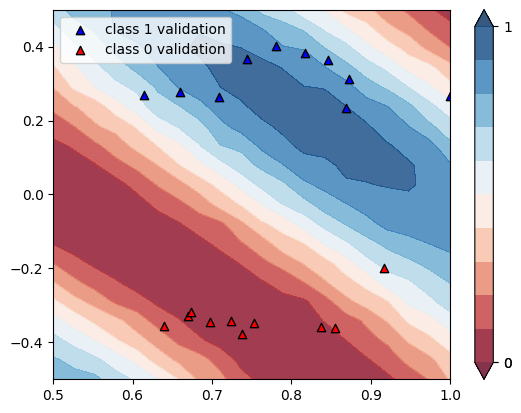

In [180]:
import matplotlib.pyplot as plt
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.5, 1, 20), np.linspace(-0.5, 0.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
predictions_grid = [get_output(circuit, f ,para) for f in X_grid]
Z = np.reshape(predictions_grid, xx.shape)
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[0, 0, 1])


# plot data

plt.scatter(
    data_test[:, 0][label_test == 1],
    data_test[:, 1][label_test == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)

plt.scatter(
    data_test[:, 0][label_test == 0],
    data_test[:, 1][label_test == 0],
    c="r",
    marker="^",
    edgecolors="k",
    label="class 0 validation",
)

plt.legend()
plt.show()